## Daily Factor Calculation Process (2024-06 ~ Curr)

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pyodbc
import pickle
import os
os.chdir('T:\\index\\95_곽용하\\운용\\코드\\')
import mf_3 as mf

# DATABASE
conn_quant = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=quant;uid=index;pwd=samsung@00')
conn_wisefn = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=wisefn;uid=index;pwd=samsung@00')

### Daily Stk Prc, Cap

#### Date

In [2]:
# 2006년 부터 (월말)
sql_date = '''  SELECT A.DT AS TRD_DT, A.YMD AS TRD_DT_
                        FROM WISEFN..TZ_DATE A
                        WHERE A.TRADE_YN = 1 AND A.MN_END_YN = 1 '''
df_date = pd.read_sql(sql_date, conn_wisefn)

C:\Users\11149\AppData\Local\Temp\ipykernel_22596\51791351.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_date = pd.read_sql(sql_date, conn_wisefn)


In [3]:
# 2006년 부터
sql_date_d = '''  SELECT A.DT AS TRD_DT, A.YMD AS TRD_DT_
                        FROM WISEFN..TZ_DATE A
                        WHERE A.TRADE_YN = 1 '''
df_date_d = pd.read_sql(sql_date_d, conn_wisefn)

C:\Users\11149\AppData\Local\Temp\ipykernel_22596\2438257765.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_date_d = pd.read_sql(sql_date_d, conn_wisefn)


#### Prc, Cap

In [4]:
# 2006년 부터
sql_mkt_data = '''  SELECT A.TRD_DT, 'A'+A.STK_CD AS STK_CD, B.MKT_VAL, B.CLOSE_PRC
                    FROM WISEFN..TS_STK_ISSUE A
                    LEFT JOIN WISEFN..TS_STK_DAILY B
                        ON A.TRD_DT = B.TRD_DT AND A.STK_CD = B.STK_CD
                    WHERE A.TRD_DT >= '20240531' AND A.KS200_TYP = 1
                    ORDER BY TRD_DT, STK_CD
                    '''
data_mkt_data = pd.read_sql(sql_mkt_data, conn_wisefn)

data_mkt_data_ = data_mkt_data.copy()
data_mkt_data_['TRD_DT'] = pd.to_datetime(data_mkt_data_['TRD_DT'],format='%Y%m%d')

C:\Users\11149\AppData\Local\Temp\ipykernel_22596\2601564770.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_mkt_data = pd.read_sql(sql_mkt_data, conn_wisefn)


In [16]:
# 수정계수
sql_adj_factor = f'''  SELECT A.DT, A.YMD AS TRD_DT, 'A'+B.STK_CD AS STK_CD, B.AADJ
                        FROM WISEFN..TZ_DATE A
                        FULL OUTER JOIN WISEFN..TS_STK_ADJ_FACTOR B
                            ON A.YMD = B.START_DT
                        WHERE A.YMD < '20240716' '''
adj_factor = pd.read_sql(sql_adj_factor, conn_wisefn)
adj_factor = adj_factor.fillna(9999)

adj_factor_pivot = adj_factor.pivot_table('AADJ','TRD_DT','STK_CD',dropna=False)
adj_factor_pivot = adj_factor_pivot.sort_index()

adj_factor_pivot.replace(9999, np.NaN, inplace=True)
adj_factor_pivot = adj_factor_pivot.ffill()
adj_factor_pivot = adj_factor_pivot.drop(9999,axis=1)

adj_factor_ = adj_factor_pivot.stack().reset_index()
adj_factor_.columns = ['TRD_DT','STK_CD','AADJ']

C:\Users\11149\AppData\Local\Temp\ipykernel_22596\2749506624.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  adj_factor = pd.read_sql(sql_adj_factor, conn_wisefn)


In [17]:
# 일별 데이터 최종
daily_mkt = pd.merge(data_mkt_data, adj_factor_,'left',['TRD_DT','STK_CD'])
daily_mkt['ADJ_PRC'] = daily_mkt.CLOSE_PRC / daily_mkt.AADJ
# daily_mkt = daily_mkt.dropna()
daily_mkt.TRD_DT = pd.to_datetime(daily_mkt.TRD_DT, format="%Y%m%d")

In [18]:
daily_mkt.tail(10)

,TRD_DT,STK_CD,MKT_VAL,CLOSE_PRC,AADJ,ADJ_PRC
6190,2024-07-15,A352820,7.838925e+12,188200.0,1.0,188200.0
6191,2024-07-15,A361610,2.965980e+12,41600.0,1.0,41600.0
6192,2024-07-15,A373220,8.388900e+13,358500.0,1.0,358500.0
6193,2024-07-15,A375500,1.323322e+12,34200.0,1.0,34200.0
6194,2024-07-15,A377300,3.781164e+12,28100.0,1.0,28100.0
6195,2024-07-15,A383220,2.313747e+12,60400.0,1.0,60400.0
6196,2024-07-15,A402340,1.421612e+13,105500.0,1.0,105500.0
6197,2024-07-15,A450080,7.017573e+12,101600.0,1.0,101600.0
6198,2024-07-15,A454910,6.060668e+12,93500.0,1.0,93500.0
6199,2024-07-15,A457190,1.344268e+12,44500.0,1.0,44500.0


### Factor Info

In [8]:
# Factor Info
sql_factor_info = '''  SELECT FactorCode, FactorGroup, FactorGroup_sub, Reverse_
                        FROM QUANT..QA_FactorMast
                        WHERE Model_yn = 1 AND D_cnt > 250  '''
factor_info = pd.read_sql(sql_factor_info, conn_quant)

factor_info['FactorGroup_sub'] = factor_info['FactorGroup_sub'].replace('',np.NaN).fillna(factor_info['FactorGroup'])

# Factor Data
sql_factor = f'''  SELECT ScoreDate, FactorCode, Code, Ratio
                    FROM QUANT..QA_FACTORDAT_
                    WHERE 1=1
                    AND ScoreDate >= '2024-05-31'
                    AND FactorCode in {tuple(factor_info['FactorCode'].unique())}  '''
data_factor = pd.read_sql(sql_factor, conn_quant)

# 팩터데이터 컬럼 정리
data_factor.columns = ['TRD_DT','FactorCode','STK_CD','VAL']
data_factor['TRD_DT'] = pd.to_datetime(data_factor['TRD_DT'])
data_factor.head(5)

# Reverse 반영하기
data_factor = pd.merge(data_factor, factor_info[['FactorCode','Reverse_']],'left','FactorCode')
data_factor['VAL'] = data_factor['VAL']*data_factor['Reverse_']

# 피봇테이블로 바꾸기
data_factor_pivot = data_factor.pivot_table('VAL',['TRD_DT','STK_CD'],'FactorCode')
data_factor_pivot = data_factor_pivot.reset_index()

# 팩터 리스트
factor_list = np.array(data_factor_pivot.columns[2:])

# 일자별 구성종목, 가격, 시가총액, 팩터 데이터
ksp_cmp_prc_factor = pd.merge(pd.merge(df_date,data_mkt_data_,'left','TRD_DT').dropna(), data_factor_pivot,'left',['TRD_DT','STK_CD'])

# 결측값을 일자별 평균 값으로 부여하기
ksp_cmp_prc_factor[factor_list] = ksp_cmp_prc_factor.groupby('TRD_DT')[factor_list].transform(lambda x: x.fillna(x.mean()))
ksp_cmp_prc_factor.dropna(inplace=True)

# 일자별 z-score
ksp_cmp_prc_factor_z = ksp_cmp_prc_factor.copy()
ksp_cmp_prc_factor_z[factor_list] = ksp_cmp_prc_factor.groupby('TRD_DT')[factor_list].transform(lambda x: (x-x.mean())/x.std())

# Stack으로 바꿔서 일자 내 종목별로 그룹별 평균 값 구하기
ksp_cmp_prc_factor_z_stack = ksp_cmp_prc_factor_z.melt(['TRD_DT','STK_CD'],factor_list)
ksp_cmp_prc_factor_z_stack.columns = ['TRD_DT','STK_CD','FactorCode','VAL']
ksp_cmp_prc_factor_z_stack_info = pd.merge(ksp_cmp_prc_factor_z_stack, factor_info, 'left', 'FactorCode')
ksp_cmp_prc_factor_z_stack_info_by_stock = ksp_cmp_prc_factor_z_stack_info.groupby(['TRD_DT','STK_CD','FactorGroup_sub'])['VAL'].mean()
ksp_cmp_prc_factor_z_stack_info_by_stock = ksp_cmp_prc_factor_z_stack_info_by_stock.reset_index()
ksp_cmp_prc_factor_by_stock = ksp_cmp_prc_factor_z_stack_info_by_stock.pivot_table('VAL',['TRD_DT','STK_CD'],'FactorGroup_sub',dropna=True).reset_index()

# 하위 분류 팩터 스타일 리스트
sub_factor = np.array(ksp_cmp_prc_factor_by_stock.columns[2:])

# 일자별로 분위 수 부여하기 (4분위)
ksp_cmp_prc_factor_by_stock_tile = ksp_cmp_prc_factor_by_stock.copy()
ksp_cmp_prc_factor_by_stock_tile[sub_factor] = ksp_cmp_prc_factor_by_stock_tile.groupby('TRD_DT')[sub_factor].transform(lambda x: pd.qcut(x, 4, labels=False)) + 1

ksp_cmp_prc_factor_by_stock_tile_stack = ksp_cmp_prc_factor_by_stock_tile.melt(['TRD_DT','STK_CD'],sub_factor)

C:\Users\11149\AppData\Local\Temp\ipykernel_22596\2075128036.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  factor_info = pd.read_sql(sql_factor_info, conn_quant)
C:\Users\11149\AppData\Local\Temp\ipykernel_22596\2075128036.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_factor = pd.read_sql(sql_factor, conn_quant)


### Daily

In [19]:
# 우선 월말 BOOK VALUE를 계산해야 함. 이걸 월 기준으로 ffill해야 함
ksp_book_value = ksp_cmp_prc_factor[['TRD_DT','STK_CD','MKT_VAL','BTM_QW']]
ksp_book_value['BV'] = ksp_book_value.MKT_VAL * ksp_book_value.BTM_QW

ksp_book_value_daily = pd.merge(daily_mkt, ksp_book_value,'left',['TRD_DT','STK_CD']).pivot_table('BV','TRD_DT','STK_CD',dropna=False).ffill().stack().reset_index()
ksp_book_value_daily.columns = ['TRD_DT','STK_CD','BV']

ksp_book_value_daily_1 = pd.merge(daily_mkt,ksp_book_value_daily,'left',['TRD_DT','STK_CD']).dropna()
ksp_book_value_daily_1['PBR'] = ksp_book_value_daily_1.MKT_VAL / ksp_book_value_daily_1.BV
ksp_book_value_daily_1 ## 일별 PBR 데이터는 이 테이블을 사용하면 됨

# Fwd Return
daily_mkt_prc = daily_mkt.pivot_table('ADJ_PRC','TRD_DT','STK_CD',dropna=False)
daily_mkt_fwd_rtn = daily_mkt_prc.pct_change(1).shift(-1)
daily_mkt_fwd_rtn_stack = daily_mkt_fwd_rtn.stack().reset_index()
daily_mkt_fwd_rtn_stack.columns = ['TRD_DT','STK_CD','FWD_RTN']

ksp_book_value_daily_2 = pd.merge(ksp_book_value_daily_1, daily_mkt_fwd_rtn_stack,'left',['TRD_DT','STK_CD'])

C:\Users\11149\AppData\Local\Temp\ipykernel_22596\3556896054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ksp_book_value['BV'] = ksp_book_value.MKT_VAL * ksp_book_value.BTM_QW


In [20]:
# 최근 월말 기준 매칭
df_date_new = pd.merge(df_date_d,df_date,'left','TRD_DT_').ffill()[['TRD_DT_x','TRD_DT_y']]
df_date_new.columns = ['TRD_DT_raw','TRD_DT']
df_date_new.tail(5)

,TRD_DT_raw,TRD_DT
8939,2024-07-10,2024-06-28
8940,2024-07-11,2024-06-28
8941,2024-07-12,2024-06-28
8942,2024-07-15,2024-06-28
8943,2024-07-16,2024-06-28


In [21]:
daily_factor_data = pd.merge(df_date_new,ksp_cmp_prc_factor_by_stock_tile_stack,'left','TRD_DT').dropna()
daily_factor_data.columns = ['TRD_DT','TRD_DT_BASE','STK_CD','FactorGroup_sub','value']

df00 = pd.merge(daily_factor_data, ksp_book_value_daily_2,'left',['TRD_DT','STK_CD']).dropna()

In [22]:
# 파일로 저장
save_path = 'T:\\index\\999_quant\\run_kyh\\sector_data\\'
with open(save_path+'Curr_daily_pbr_cap_adjprc_data.pkl', 'wb') as f:
    pickle.dump(df00, f)

### Factor Long-Short Portfolio

In [23]:
df01 = df00.copy()
df01['sqrt_cap'] = np.log1p(df01['MKT_VAL'])
df01['cap_pbr'] = df01.sqrt_cap * df01.PBR
df01['cap_fwd_rtn'] = df01.sqrt_cap * df01.FWD_RTN

df03 = df01.groupby(['TRD_DT','FactorGroup_sub','value'])['cap_fwd_rtn'].sum() / df01.groupby(['TRD_DT','FactorGroup_sub','value'])['sqrt_cap'].sum()
df03 = df03.reset_index()
df03.columns = ['TRD_DT','FactorGroup_sub','value','fwd_rtn']

# 4분위 - 1분위
df03_4q = df03[df03['value']==4]
df03_1q = df03[df03['value']==1]

df03_4q = df03_4q.pivot_table('fwd_rtn','TRD_DT','FactorGroup_sub',dropna=False)
df03_1q = df03_1q.pivot_table('fwd_rtn','TRD_DT','FactorGroup_sub',dropna=False)

df03_ls = df03_4q - df03_1q

<AxesSubplot:xlabel='TRD_DT'>

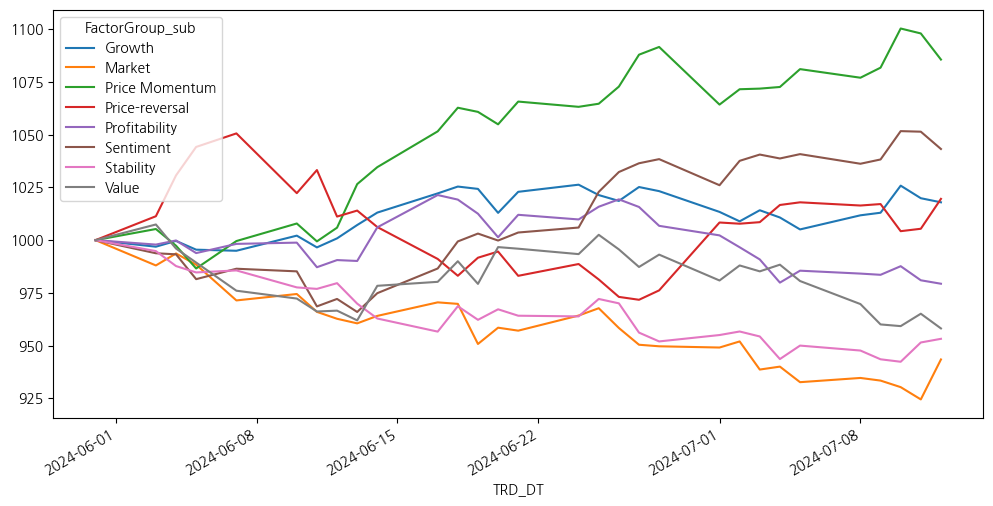

In [26]:
((1+df03_ls).shift(1).fillna(1).cumprod()*1000).plot(figsize=(12,6))

In [25]:
df03_ls

FactorGroup_sub,Growth,Market,Price Momentum,Price-reversal,Profitability,Sentiment,Stability,Value
TRD_DT,,,,,,,,
2024-05-31,-0.003111,-0.011998,0.005274,0.011335,-0.002111,-0.006222,-0.005193,0.007423
2024-06-03,0.002755,0.005744,-0.007872,0.019126,0.001953,-0.000506,-0.007132,-0.011340
2024-06-04,-0.004162,-0.005336,-0.010826,0.013097,-0.005979,-0.011851,-0.003061,-0.006650
2024-06-05,-0.000515,-0.017155,0.013183,0.006144,0.004391,0.005035,0.000969,-0.013492
2024-06-07,0.007204,0.003137,0.008323,-0.026953,0.000595,-0.001265,-0.008161,-0.003812
2024-06-10,-0.005558,-0.008697,-0.008410,0.010699,-0.011674,-0.016856,-0.000726,-0.006312
2024-06-11,0.004289,-0.003385,0.006504,-0.021336,0.003434,0.003650,0.002782,0.000425
2024-06-12,0.006322,-0.002257,0.020522,0.002812,-0.000424,-0.006359,-0.009909,-0.004782
2024-06-13,0.005853,0.003684,0.007835,-0.007698,0.016103,0.009227,-0.007275,0.017042
